In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, MultiHeadAttention, Flatten, Concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModel
import torch

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, LayerNormalization, GlobalAveragePooling1D, Conv1D

In [2]:
statistics = pd.read_csv("istatistikler.csv")

news = pd.read_csv("haberler.csv")

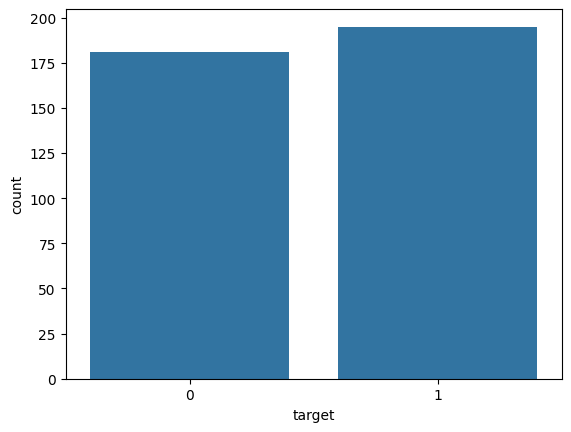

In [3]:
# target
sns.countplot(data=statistics, x="target")
plt.show()

In [4]:
news.head()

,title,text,clean_text,date,year,month,day
0,Savunmada Gelişenler ve yerinde sayanlar,Lefteris Moutis/moutis@eurohoops.net\nEurohoop...,lefteris eurohoops olarak eurolig deki takımla...,2015-03-02 13:56:00,2015,3,2
1,Galatasaray Fenerbahçe’ye Teslim Olmuyor,By Eurohoops team/info@eurohoops.netGalatasara...,galatasaraydüşüyor ama asla teslim olmuyor. si...,2015-05-24 17:10:00,2015,5,24
2,Avrupa’da Maç Programı ve Yayın Akışı,By Eurohoops Team/info@eurohoops.net\nEuroleag...,euroleague ve eurocup ta mücadele edecek takım...,2015-10-26 12:46:00,2015,10,26
3,“Atılan Üçlükler Fenerbahçe’yi Zor Durumda Bır...,"Torku Konyaspor koçu Aziz Bekir, maç sonu yapt...","torku konyaspor koçu aziz bekir, maç sonu yapt...",2015-10-26 21:06:00,2015,10,26
4,Fenerbahçe Tarihinde İlk!,By Eurohoops Team/info@eurohoops.net\nFenerbah...,"fenerbahçe, torku konyaspor maçında tarihinde ...",2015-10-27 10:34:00,2015,10,27


In [5]:
statistics.head()

,Opposing Team,IsHome,Points,Performance Index Rating,Two-point %,Three-point %,Free-throw %,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Turnovers,Day,Month,Year,Date,target
0,CSKA Moscow,1,81.0,76.0,42.9,38.5,62.5,13.0,30.0,43.0,20.0,5.0,5.0,19.0,2,1,2015,2015-01-02,0
1,Nizhny Novgorod,0,78.0,80.0,56.9,33.3,35.7,12.0,21.0,33.0,8.0,6.0,3.0,4.0,9,1,2015,2015-01-09,0
2,Olympiacos Piraeus,1,68.0,65.0,51.4,39.1,45.5,7.0,19.0,26.0,14.0,5.0,6.0,11.0,16,1,2015,2015-01-16,0
3,EA7 Emporio Armani Milan,0,82.0,99.0,63.0,21.1,85.7,13.0,20.0,33.0,18.0,9.0,3.0,9.0,22,1,2015,2015-01-22,1
4,Unicaja Malaga,0,68.0,81.0,57.9,27.8,69.2,8.0,30.0,38.0,16.0,9.0,3.0,15.0,30,1,2015,2015-01-30,0


### Data Alignment

In [6]:
statistics['Date'] = pd.to_datetime(statistics['Date'])
news['date'] = pd.to_datetime(news['date'])

In [7]:
def get_related_news(game_date, news_df, window_days=3):
    # Maçtan önceki pencereyi belirle
    start_date = game_date - timedelta(days=window_days)
    end_date = game_date - timedelta(days=1) # Maç gününü dahil etmiyoruz (garanti olsun)

    # O tarihler arasındaki haberleri filtrele
    mask = (news_df['date'] >= start_date) & (news_df['date'] <= end_date)
    related_news = news_df.loc[mask, 'clean_text'].tolist()

    # Haberleri tek bir metin olarak birleştir
    if len(related_news) > 0:
        return " ".join(related_news)
    else:
        return "no_news_available"

# Yeni sütunu oluştur
statistics['combined_news'] = statistics['Date'].apply(lambda x: get_related_news(x, news))

In [8]:
with pd.option_context('display.max_colwidth', None):
    display(statistics.iloc[100])

,100
Opposing Team,Panathinaikos Superfoods Athens
IsHome,1
Points,67.0
Performance Index Rating,77.0
Two-point %,48.8
Three-point %,26.3
Free-throw %,71.4
Offensive rebounds,12.0
Defensive rebounds,26.0
Total rebounds,38.0


In [9]:
df = statistics.copy()
df.head()

,Opposing Team,IsHome,Points,Performance Index Rating,Two-point %,Three-point %,Free-throw %,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Turnovers,Day,Month,Year,Date,target,combined_news
0,CSKA Moscow,1,81.0,76.0,42.9,38.5,62.5,13.0,30.0,43.0,20.0,5.0,5.0,19.0,2,1,2015,2015-01-02,0,no_news_available
1,Nizhny Novgorod,0,78.0,80.0,56.9,33.3,35.7,12.0,21.0,33.0,8.0,6.0,3.0,4.0,9,1,2015,2015-01-09,0,no_news_available
2,Olympiacos Piraeus,1,68.0,65.0,51.4,39.1,45.5,7.0,19.0,26.0,14.0,5.0,6.0,11.0,16,1,2015,2015-01-16,0,no_news_available
3,EA7 Emporio Armani Milan,0,82.0,99.0,63.0,21.1,85.7,13.0,20.0,33.0,18.0,9.0,3.0,9.0,22,1,2015,2015-01-22,1,no_news_available
4,Unicaja Malaga,0,68.0,81.0,57.9,27.8,69.2,8.0,30.0,38.0,16.0,9.0,3.0,15.0,30,1,2015,2015-01-30,0,no_news_available


## MLP (statistics) + BERTurk (news)


In [10]:
X = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"])
y = df["target"]

In [11]:
# Metrikleri tutmak için listeler
fold_accuracies, fold_f1s, fold_precisions, fold_recalls = [], [], [], []
fold_sensitivities, fold_specificities = [], []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cv)
    X_val_scaled = scaler.transform(X_val_cv)

    # MODEL
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(30, activation="relu"),
        Dense(15, activation="relu"),
        Dense(15, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_train_scaled, y_train_cv, epochs=50, batch_size=32, verbose=0)

    # TAHMİN
    y_pred = (model.predict(X_val_scaled) > 0.5).astype("int32")

    # METRİKLER
    acc = accuracy_score(y_val_cv, y_pred)
    f1 = f1_score(y_val_cv, y_pred)
    prec = precision_score(y_val_cv, y_pred)
    rec = recall_score(y_val_cv, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Listelere ekleme
    fold_accuracies.append(acc)
    fold_f1s.append(f1)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)

    print(f"Fold {fold} - Acc: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}, Sens: {sensitivity:.4f}, Spec: {specificity:.4f}")

print("\n" + "="*30)
print("FINAL RESULTS (Mean ± Std)")
print(f"Accuracy:    {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"F1-Score:    {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")
print(f"Precision:   {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall:      {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"Sensitivity: {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}")
print(f"Specificity: {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}")
print("="*30)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Fold 1 - Acc: 0.8684, F1: 0.8718, Recall: 0.8718, Sens: 0.8718, Spec: 0.8649
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
Fold 2 - Acc: 0.9200, F1: 0.9231, Recall: 0.9231, Sens: 0.9231, Spec: 0.9167


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Fold 3 - Acc: 0.9333, F1: 0.9383, Recall: 0.9744, Sens: 0.9744, Spec: 0.8889
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Fold 4 - Acc: 0.9333, F1: 0.9351, Recall: 0.9231, Sens: 0.9231, Spec: 0.9444
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Fold 5 - Acc: 0.9200, F1: 0.9211, Recall: 0.8974, Sens: 0.8974, Spec: 0.9444

FINAL RESULTS (Mean ± Std)
Accuracy:    0.9150 ± 0.0240
F1-Score:    0.9179 ± 0.0240
Precision:   0.9186 ± 0.0282
Recall:      0.9179 ± 0.0340
Sensitivity: 0.9179 ± 0.0340
Specificity: 0.9119 ± 0.0312


In [12]:
# 1. Model ve Tokenizer Yükleme (BERTurk)
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [13]:
def get_bert_embeddings(text_list):
    # BERT'in 512 token sınırı vardır, metinleri buna göre kırpıyoruz
    inputs = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # [CLS] token'ının çıktısını alıyoruz (Metnin tamamını temsil eden 768-D vektör)
    # Rehberdeki text_feat (768) buna karşılık gelir [cite: 10]
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# 2. Veri Setindeki Metinleri Vektöre Dönüştürme
print("Metinler vektörleştiriliyor (Bu işlem zaman alabilir)...")
# Bellek sorunu yaşamamak için küçük parçalar (batch) halinde işliyoruz
text_features = []
for i in range(0, len(statistics)):
    text = statistics['combined_news'].iloc[i]
    emb = get_bert_embeddings([text])
    text_features.append(emb[0])

# Sonucu ana tabloya eklemek üzere numpy array yapıyoruz
X_text_features = np.array(text_features)
print(f"Metin özellik matrisi hazır: {X_text_features.shape}") # (Maç Sayısı, 768)

Metinler vektörleştiriliyor (Bu işlem zaman alabilir)...
Metin özellik matrisi hazır: (376, 768)


In [14]:
# Metrik listelerini hazırla
text_acc, text_f1, text_prec, text_rec = [], [], [], []
text_sens, text_spec = [], []

print("BERTurk Single-Modality Testi Başlıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_features, y), 1):
    # Veriyi böl
    X_t_train, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_t_train, y_t_val = y[train_idx], y[val_idx]

    # Model: BERT vektörlerini sınıflayacak basit bir MLP
    model_text = Sequential([
        Input(shape=(768,)), # BERT embedding boyutu
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model_text.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model_text.fit(X_t_train, y_t_train, epochs=20, batch_size=16, verbose=0)

    # Tahmin
    y_pred = (model_text.predict(X_t_val) > 0.5).astype(int)

    # Metrikleri hesapla
    acc = accuracy_score(y_t_val, y_pred)
    f1 = f1_score(y_t_val, y_pred)
    prec = precision_score(y_t_val, y_pred)
    rec = recall_score(y_t_val, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_t_val, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Listelere ekle
    text_acc.append(acc)
    text_f1.append(f1)
    text_prec.append(prec)
    text_rec.append(rec)
    text_sens.append(sensitivity)
    text_spec.append(specificity)

    print(f"Fold {fold} - Acc: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}")

# Dökümandaki "Mean ± Std" formatında raporla
print("\n" + "="*40)
print("TEXT-ONLY (BERTurk) FINAL RESULTS")
print(f"Accuracy:    {np.mean(text_acc):.4f} ± {np.std(text_acc):.4f}")
print(f"F1-Score:    {np.mean(text_f1):.4f} ± {np.std(text_f1):.4f}")
print(f"Recall:      {np.mean(text_rec):.4f} ± {np.std(text_rec):.4f}")
print(f"Precision:   {np.mean(text_prec):.4f} ± {np.std(text_prec):.4f}")
print(f"Sensitivity: {np.mean(text_sens):.4f} ± {np.std(text_sens):.4f}")
print(f"Specificity: {np.mean(text_spec):.4f} ± {np.std(text_spec):.4f}")
print("="*40)

BERTurk Single-Modality Testi Başlıyor...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Fold 1 - Acc: 0.5132, F1: 0.5432, Recall: 0.5641
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 2 - Acc: 0.4933, F1: 0.5870, Recall: 0.6923
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Fold 3 - Acc: 0.4667, F1: 0.5122, Recall: 0.5385
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Fold 4 - Acc: 0.3867, F1: 0.4103, Recall: 0.4103
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Fold 5 - Acc: 0.4133, F1: 0.3714, Recall: 0.3333

TEXT-ONLY (BERTurk) FINAL RESULTS
Accuracy:    0.4546 ± 0.0477
F1-Score:    0.4848 ± 0.0813
Recall:      0.5077 ± 0.1250
Precision:   0.4702 ± 0.0467
Sensitivity: 0.5077 ± 0.1250
Specificity: 0.3974 ± 0.0776


### Early Fusion

In [15]:
# 1. Ham Verileri Hazırla
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
# X_text_features zaten elimizde (376, 768)
X_combined_raw = np.concatenate([X_stats_raw, X_text_features], axis=1)
y = df["target"].values

# Metrik listeleri
ef_metrics = {
    'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Early Fusion Başlatılıyor... Veri boyutu: {X_combined_raw.shape}")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_combined_raw, y), 1):
    X_train, X_val = X_combined_raw[train_idx], X_combined_raw[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    scaler = StandardScaler()
    X_train[:, :12] = scaler.fit_transform(X_train[:, :12])
    X_val[:, :12] = scaler.transform(X_val[:, :12])

    # Model Mimarisi
    model = Sequential([
        Input(shape=(X_combined_raw.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

    # Tahmin
    y_pred = (model.predict(X_val) > 0.5).astype("int32")

    # Metriklerin Hesaplanması
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Listelere ekle
    ef_metrics['acc'].append(acc); ef_metrics['f1'].append(f1)
    ef_metrics['prec'].append(prec); ef_metrics['rec'].append(rec)
    ef_metrics['sens'].append(sens); ef_metrics['spec'].append(spec)

    print(f"Fold {fold} -> Acc: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}")

# Final Raporlama
print("\n" + "="*45)
print("EARLY FUSION FINAL RESULTS (Mean ± Std)")
for key, values in ef_metrics.items():
    print(f"{key.upper():10}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print("="*45)

Early Fusion Başlatılıyor... Veri boyutu: (376, 780)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 1 -> Acc: 0.7895, F1: 0.8000, Recall: 0.8205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 2 -> Acc: 0.8000, F1: 0.8101, Recall: 0.8205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Fold 3 -> Acc: 0.8800, F1: 0.8889, Recall: 0.9231
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Fold 4 -> Acc: 0.9333, F1: 0.9351, Recall: 0.9231
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Fold 5 -> Acc: 0.7333, F1: 0.7727, Recall: 0.8718

EARLY FUSION FINAL RESULTS (Mean ± Std)
ACC       : 0.8272 ± 0.0707
F1        : 0.8414 ± 0.0607
PREC      : 0.8158 ± 0.0841
REC       : 0.8718 ± 0.0459
SENS      : 0.8718 ± 0.0459
SPEC      : 0.7791 ± 0.1176


### Intermediate Fusion

In [16]:
def create_intermediate_model(stats_dim, text_dim):
    # 1. Giriş Katmanları
    stats_input = Input(shape=(stats_dim,), name='stats_input')
    text_input = Input(shape=(text_dim,), name='text_input')

    # 2. Projection (Boyut Eşitleme)
    stats_feat = Dense(128, activation='relu')(stats_input)
    text_feat = Dense(128, activation='relu')(text_input)

    # 3. Boyut Genişletme (Attention için 3D Tensör gerekiyor)
    stats_feat_expanded = Reshape((1, 128))(stats_feat)
    text_feat_expanded = Reshape((1, 128))(text_feat)

    # 4. Cross-Attention Mekanizması
    attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(
        query=stats_feat_expanded,
        value=text_feat_expanded
    )

    # 5. Attention Çıktısını Birleştirme
    attn_flat = Flatten()(attn_output)
    combined = Concatenate()([attn_flat, stats_feat])

    # 6. Classifier
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[stats_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrikleri tutmak için sözlük
int_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []}

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values

print("Intermediate Fusion (Cross-Attention) Başlatılıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    # Veriyi ayır
    X_s_tr, X_s_val = X_stats_raw[train_idx], X_stats_raw[val_idx]
    X_t_tr, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_s_tr = scaler.fit_transform(X_s_tr)
    X_s_val = scaler.transform(X_s_val)

    # Model oluştur ve eğit
    model = create_intermediate_model(X_s_tr.shape[1], X_t_tr.shape[1])
    model.fit([X_s_tr, X_t_tr], y_tr, epochs=30, batch_size=16, verbose=0)

    # Tahmin
    y_pred = (model.predict([X_s_val, X_t_val]) > 0.5).astype("int32")

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    int_results['acc'].append(accuracy_score(y_val, y_pred))
    int_results['f1'].append(f1_score(y_val, y_pred))
    int_results['prec'].append(precision_score(y_val, y_pred))
    int_results['rec'].append(recall_score(y_val, y_pred))
    int_results['sens'].append(tp / (tp + fn))
    int_results['spec'].append(tn / (tn + fp))

    print(f"Fold {fold} - Acc: {int_results['acc'][-1]:.4f}, F1: {int_results['f1'][-1]:.4f}, Sens: {int_results['sens'][-1]:.4f}, Spec: {int_results['spec'][-1]:.4f}")

# Final Raporlama
print("\n" + "="*45)
print("INTERMEDIATE FUSION FINAL RESULTS")
for metrik, degerler in int_results.items():
    print(f"{metrik.upper():10}: {np.mean(degerler):.4f} ± {np.std(degerler):.4f}")
print("="*45)

Intermediate Fusion (Cross-Attention) Başlatılıyor...

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
Fold 1 - Acc: 0.8421, F1: 0.8378, Sens: 0.7949, Spec: 0.8919
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 2 - Acc: 0.8533, F1: 0.8571, Sens: 0.8462, Spec: 0.8611
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
Fold 3 - Acc: 0.8933, F1: 0.8947, Sens: 0.8718, Spec: 0.9167
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
Fold 4 - Acc: 0.9200, F1: 0.9250, Sens: 0.9487, Spec: 0.8889
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
Fold 5 - Acc: 0.9067, F1: 0.9091, Sens: 0.8974, Spec: 0.9167

INTERMEDIATE FUSION FINAL RESULTS
ACC       : 0.8831 ± 0.0303
F1        : 0.8848 ± 0.0325
PREC      : 0.8993 ± 0.0200
REC       : 0.8718 ± 0.0513
SENS      : 0.8718 ± 0.0513
SPEC      : 0.8950 ± 0.0207


### Late Fusion

In [17]:
# 1. Hazırlık
methods = ["Majority", "Softmax_Mean", "Weighted", "Stacking"]
# Tüm metrikleri tutmak için yapı
late_results = {m: {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []} for m in methods}

# Ham istatistik verisi
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Late Fusion İşlemleri Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    # Veri setlerini ayır
    X_s_tr, X_s_val = X_stats_raw[train_idx], X_stats_raw[val_idx]
    X_t_tr, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- STANDARTLAŞTIRMA (Leakage Önleme) ---
    scaler = StandardScaler()
    X_s_tr = scaler.fit_transform(X_s_tr)
    X_s_val = scaler.transform(X_s_val)

    # 2. Model 1: İstatistik Modeli (MLP)
    model_stats = Sequential([Input(shape=(X_s_tr.shape[1],)), Dense(32, activation='relu'), Dense(1, activation='sigmoid')])
    model_stats.compile(optimizer='adam', loss='binary_crossentropy')
    model_stats.fit(X_s_tr, y_tr, epochs=30, batch_size=16, verbose=0)
    prob_stats = model_stats.predict(X_s_val, verbose=0).flatten()

    # 3. Model 2: Metin Modeli (BERT Features + MLP)
    model_text = Sequential([Input(shape=(X_t_tr.shape[1],)), Dense(64, activation='relu'), Dense(1, activation='sigmoid')])
    model_text.compile(optimizer='adam', loss='binary_crossentropy')
    model_text.fit(X_t_tr, y_tr, epochs=30, batch_size=16, verbose=0)
    prob_text = model_text.predict(X_t_val, verbose=0).flatten()

    # --- FUSION YÖNTEMLERİ ---
    # Softmax Mean
    p_soft = (prob_stats + prob_text) / 2

    # Weighted (Stats %70 - Text %30)
    p_weight = (prob_stats * 0.7) + (prob_text * 0.3)

    # Majority (OR Logic: İkisinden biri 1 derse 1)
    p_maj = (( (prob_stats > 0.5).astype(int) + (prob_text > 0.5).astype(int) ) >= 1).astype(int)

    # Stacking
    X_meta_tr = np.column_stack([model_stats.predict(X_s_tr, verbose=0), model_text.predict(X_t_tr, verbose=0)])
    X_meta_val = np.column_stack([prob_stats, prob_text])
    meta_model = LogisticRegression().fit(X_meta_tr, y_tr)
    p_stack = meta_model.predict(X_meta_val)

    # --- METRİKLERİ KAYDET VE YAZDIR ---
    preds_dict = {
        "Softmax_Mean": (p_soft > 0.5).astype(int),
        "Weighted": (p_weight > 0.5).astype(int),
        "Majority": p_maj,
        "Stacking": p_stack
    }

    print(f"\n>>> Fold {fold} Sonuçları:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'Sens':6} | {'Spec':6}")
    print("-" * 55)

    for m in methods:
        y_p = preds_dict[m]
        tn, fp, fn, tp = confusion_matrix(y_val, y_p).ravel()

        # Metrikleri listelere ekle
        late_results[m]['acc'].append(accuracy_score(y_val, y_p))
        late_results[m]['f1'].append(f1_score(y_val, y_p))
        late_results[m]['prec'].append(precision_score(y_val, y_p, zero_division=0))
        late_results[m]['rec'].append(recall_score(y_val, y_p))
        late_results[m]['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        late_results[m]['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

        # Fold bazlı anlık print
        print(f"{m:15} | {late_results[m]['f1'][-1]:.4f} | {late_results[m]['acc'][-1]:.4f} | "
              f"{late_results[m]['sens'][-1]:.4f} | {late_results[m]['spec'][-1]:.4f}")

# --- FİNAL RAPORLAMA ---
print("\n" + "="*70)
print(f"{'LATE FUSION FINAL':15} | {'F1 (Mean ± Std)':20} | {'Acc (Mean ± Std)':20}")
print("-" * 70)
for m in methods:
    f1_mean, f1_std = np.mean(late_results[m]['f1']), np.std(late_results[m]['f1'])
    acc_mean, acc_std = np.mean(late_results[m]['acc']), np.std(late_results[m]['acc'])
    print(f"{m:15} | {f1_mean:.4f} ± {f1_std:.3f} | {acc_mean:.4f} ± {acc_std:.3f}")
print("="*70)

Late Fusion İşlemleri Başlatılıyor (5-Fold CV)...


>>> Fold 1 Sonuçları:
Method          | F1     | Acc    | Sens   | Spec  
-------------------------------------------------------
Majority        | 0.7957 | 0.7500 | 0.9487 | 0.5405
Softmax_Mean    | 0.8395 | 0.8289 | 0.8718 | 0.7838
Weighted        | 0.8750 | 0.8684 | 0.8974 | 0.8378
Stacking        | 0.8706 | 0.8553 | 0.9487 | 0.7568

>>> Fold 2 Sonuçları:
Method          | F1     | Acc    | Sens   | Spec  
-------------------------------------------------------
Majority        | 0.7835 | 0.7200 | 0.9744 | 0.4444
Softmax_Mean    | 0.8000 | 0.7867 | 0.8205 | 0.7500
Weighted        | 0.8684 | 0.8667 | 0.8462 | 0.8889
Stacking        | 0.8421 | 0.8400 | 0.8205 | 0.8611

>>> Fold 3 Sonuçları:
Method          | F1     | Acc    | Sens   | Spec  
-------------------------------------------------------
Majority        | 0.8000 | 0.7467 | 0.9744 | 0.5000
Softmax_Mean    | 0.9000 | 0.8933 | 0.9231 | 0.8611
Weighted        | 0.9367 | 0.9333 | 

### BiLSTM

In [18]:
# 1. VERİ HAZIRLIĞI
texts = statistics['combined_news'].astype(str).tolist()
y = statistics['target'].values

max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_text_padded = pad_sequences(sequences, maxlen=max_len)

# 2. METRİK TAKİBİ İÇİN SÖZLÜK
bilstm_metrics = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []}

# 3. 5-FOLD CV DÖNGÜSÜ
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("BiLSTM Metin Modeli Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_padded, y), 1):
    X_tr, X_val = X_text_padded[train_idx], X_text_padded[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- MODEL ---
    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(max_words, 128),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=0)

    # --- TAHMİN VE METRİKLER ---
    y_pred = (model.predict(X_val) > 0.5).astype("int32")

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    bilstm_metrics['acc'].append(accuracy_score(y_val, y_pred))
    bilstm_metrics['f1'].append(f1_score(y_val, y_pred))
    bilstm_metrics['prec'].append(precision_score(y_val, y_pred))
    bilstm_metrics['rec'].append(recall_score(y_val, y_pred))
    bilstm_metrics['sens'].append(tp / (tp + fn))
    bilstm_metrics['spec'].append(tn / (tn + fp))

    print(f"Fold {fold} - Acc: {bilstm_metrics['acc'][-1]:.4f}, "
          f"F1: {bilstm_metrics['f1'][-1]:.4f}, "
          f"Recall: {bilstm_metrics['rec'][-1]:.4f}, "
          f"Spec: {bilstm_metrics['spec'][-1]:.4f}")

# --- FİNAL RAPORLAMA ---
print("\n" + "="*45)
print("BiLSTM TEXT MODEL FINAL RESULTS")
for metrik, degerler in bilstm_metrics.items():
    print(f"{metrik.upper():10}: {np.mean(degerler):.4f} ± {np.std(degerler):.4f}")
print("="*45)

BiLSTM Metin Modeli Testi Başlatılıyor (5-Fold CV)...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 1 - Acc: 0.4868, F1: 0.4348, Recall: 0.3846, Spec: 0.5946
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Fold 2 - Acc: 0.5467, F1: 0.5641, Recall: 0.5641, Spec: 0.5278
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Fold 3 - Acc: 0.5200, F1: 0.4706, Recall: 0.4103, Spec: 0.6389
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Fold 4 - Acc: 0.4667, F1: 0.3548, Recall: 0.2821, Spec: 0.6667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Fold 5 - Acc: 0.4533, F1: 0.5287, Recall: 0.5897, Spec: 0.3056

BiLSTM TEXT MODEL FINAL RESULTS
ACC       : 0.4947 ± 0.0343
F1        : 0.4706 ± 0.0732
PREC      : 0.5147 ± 0.0364
REC       : 0.4462 ± 0.1154
SENS      : 0.4462 ± 0.1154
SPEC      : 0.5467 ± 0.1294


### DistilBERT

In [19]:
# 1. DistilBERT Modelini Yükle
distil_model_name = "dbmdz/distilbert-base-turkish-cased"
distil_tokenizer = AutoTokenizer.from_pretrained(distil_model_name)
distil_model = AutoModel.from_pretrained(distil_model_name)

def get_distilbert_embeddings(text_list):
    inputs = distil_tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = distil_model(**inputs)
    # [CLS] token'ı (0. indeks) metnin anlamsal özetidir
    return outputs.last_hidden_state[:, 0, :].numpy()

# 2. Öznitelik Çıkarımı (Feature Extraction)
print("DistilBERT özellikleri çıkarılıyor (Bu işlem verinin boyutuna göre vakit alabilir)...")
distil_text_features = []
for i in range(len(statistics)):
    text = str(statistics['combined_news'].iloc[i])
    emb = get_distilbert_embeddings([text])
    distil_text_features.append(emb[0])

X_distil_feat = np.array(distil_text_features)
y = statistics['target'].values
print(f"Özellik matrisi hazır: {X_distil_feat.shape}")

# 3. Metrik Takibi İçin Yapı (Doküman Madde 6)
dist_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []}

# 4. Single-Modality Testi (5-Fold CV)
print("\nDistilBERT 5-Fold Cross-Validation Başlatılıyor...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_distil_feat, y), 1):
    X_tr, X_val = X_distil_feat[train_idx], X_distil_feat[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- MODEL  ---
    model = Sequential([
        Input(shape=(768,)), # DistilBERT embedding boyutu
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model.fit(X_tr, y_tr, epochs=15, batch_size=16, verbose=0)

    # Tahmin
    y_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int)

    # --- METRİKLERİN HESAPLANMASI ---
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    dist_results['acc'].append(accuracy_score(y_val, y_pred))
    dist_results['f1'].append(f1_score(y_val, y_pred))
    dist_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    dist_results['rec'].append(recall_score(y_val, y_pred))
    dist_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    dist_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"Fold {fold} | F1: {dist_results['f1'][-1]:.4f} | Acc: {dist_results['acc'][-1]:.4f} | Sens: {dist_results['sens'][-1]:.4f}")

# --- FİNAL RAPORLAMA  ---
print("\n" + "="*55)
print(f"{'DISTILBERT FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in dist_results:
    m_mean = np.mean(dist_results[m])
    m_std = np.std(dist_results[m])
    print(f"{m.upper():30} | {m_mean:.4f} ± {m_std:.3f}")
print("="*55)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

DistilBERT özellikleri çıkarılıyor (Bu işlem verinin boyutuna göre vakit alabilir)...
Özellik matrisi hazır: (376, 768)

DistilBERT 5-Fold Cross-Validation Başlatılıyor...
Fold 1 | F1: 0.6792 | Acc: 0.5526 | Sens: 0.9231
Fold 2 | F1: 0.6600 | Acc: 0.5467 | Sens: 0.8462
Fold 3 | F1: 0.6538 | Acc: 0.5200 | Sens: 0.8718
Fold 4 | F1: 0.6275 | Acc: 0.4933 | Sens: 0.8205
Fold 5 | F1: 0.6471 | Acc: 0.5200 | Sens: 0.8462

DISTILBERT FINAL REPORT        | Mean ± Std
-------------------------------------------------------
ACC                            | 0.5265 ± 0.021
F1                             | 0.6535 ± 0.017
PREC                           | 0.5266 ± 0.012
REC                            | 0.8615 ± 0.035
SENS                           | 0.8615 ± 0.035
SPEC                           | 0.1658 ± 0.030


### TabTransformer

In [20]:
def create_tabular_transformer(input_dim):
    inputs = Input(shape=(input_dim,))

    # 1. Feature Projection
    # Sayısal özellikleri 64 boyutlu bir temsil uzayına iz düşürüyoruz
    x = Dense(64, activation='relu')(inputs)

    # MultiHeadAttention 3B (Batch, Sequence, Dim) beklediği için Reshape yapıyoruz
    x = Reshape((1, 64))(x)

    # 2. Transformer Bloğu
    # Self-attention mekanizması sayısal özellikler arasındaki gizli ilişkileri öğrenir
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(attention_output + x)

    # 3. Classification Head
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Final Çıktı
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrikleri tutmak için yapı
tab_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []}

# Ham veriyi kullanıyoruz (Leakage önlemek için)
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values

print("Tabular Transformer Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_tr_raw, X_val_raw = X_stats_raw[train_idx], X_stats_raw[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    # Modeli oluştur
    model = create_tabular_transformer(X_tr.shape[1])

    # Eğitim
    model.fit(X_tr, y_tr, epochs=30, batch_size=16, verbose=0)

    # Tahmin
    y_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int)

    # --- METRİKLER ---
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    tab_results['acc'].append(accuracy_score(y_val, y_pred))
    tab_results['f1'].append(f1_score(y_val, y_pred))
    tab_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    tab_results['rec'].append(recall_score(y_val, y_pred))
    tab_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    tab_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"Fold {fold} | F1: {tab_results['f1'][-1]:.4f} | Acc: {tab_results['acc'][-1]:.4f} | Sens: {tab_results['sens'][-1]:.4f}")

# --- FİNAL RAPORLAMA ---
print("\n" + "="*55)
print(f"{'TABULAR TRANSFORMER REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in tab_results:
    m_mean = np.mean(tab_results[m])
    m_std = np.std(tab_results[m])
    print(f"{m.upper():30} | {m_mean:.4f} ± {m_std:.3f}")
print("="*55)

Tabular Transformer Testi Başlatılıyor (5-Fold CV)...

Fold 1 | F1: 0.8434 | Acc: 0.8289 | Sens: 0.8974
Fold 2 | F1: 0.9211 | Acc: 0.9200 | Sens: 0.8974
Fold 3 | F1: 0.9048 | Acc: 0.8933 | Sens: 0.9744
Fold 4 | F1: 0.9367 | Acc: 0.9333 | Sens: 0.9487
Fold 5 | F1: 0.9091 | Acc: 0.9067 | Sens: 0.8974

TABULAR TRANSFORMER REPORT     | Mean ± Std
-------------------------------------------------------
ACC                            | 0.8965 ± 0.036
F1                             | 0.9030 ± 0.032
PREC                           | 0.8864 ± 0.057
REC                            | 0.9231 ± 0.032
SENS                           | 0.9231 ± 0.032
SPEC                           | 0.8680 ± 0.073


### Informer

In [21]:
def create_informer_lite_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # 1. Feature Projection
    x = Dense(64, activation='relu')(inputs)
    x = Reshape((1, 64))(x)

    # 2. Informer-style Attention Block
    # 8 başlıklı attention ile istatistikler arası global ilişkileri yakalama
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = LayerNormalization()(attention_output + x)

    # Informer Distilling (Conv1D ile en önemli özellikleri süzme/damıtma)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
    x = Dropout(0.1)(x)

    # 3. Sınıflandırma Başlığı
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrik takib
inf_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': []}

# Ham veriyi al
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values

print("Informer-Lite Sayısal Model Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_tr_raw, X_val_raw = X_stats_raw[train_idx], X_stats_raw[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = create_informer_lite_model(X_tr.shape[1])

    # Eğitim
    model.fit(X_tr, y_tr, epochs=25, batch_size=16, verbose=0)

    # Tahmin
    y_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int)

    # --- METRİKLER ---
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    inf_results['acc'].append(accuracy_score(y_val, y_pred))
    inf_results['f1'].append(f1_score(y_val, y_pred))
    inf_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    inf_results['rec'].append(recall_score(y_val, y_pred))
    inf_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    inf_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"Fold {fold} | F1: {inf_results['f1'][-1]:.4f} | Acc: {inf_results['acc'][-1]:.4f} | Sens: {inf_results['sens'][-1]:.4f}")

# --- FİNAL RAPORLAMA ---
print("\n" + "="*55)
print(f"{'INFORMER-LITE FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in inf_results:
    m_mean = np.mean(inf_results[m])
    m_std = np.std(inf_results[m])
    print(f"{m.upper():30} | {m_mean:.4f} ± {m_std:.3f}")
print("="*55)

Informer-Lite Sayısal Model Testi Başlatılıyor (5-Fold CV)...

Fold 1 | F1: 0.8471 | Acc: 0.8289 | Sens: 0.9231
Fold 2 | F1: 0.9231 | Acc: 0.9200 | Sens: 0.9231
Fold 3 | F1: 0.9136 | Acc: 0.9067 | Sens: 0.9487
Fold 4 | F1: 0.9474 | Acc: 0.9467 | Sens: 0.9231
Fold 5 | F1: 0.8831 | Acc: 0.8800 | Sens: 0.8718

INFORMER-LITE FINAL REPORT     | Mean ± Std
-------------------------------------------------------
ACC                            | 0.8965 ± 0.040
F1                             | 0.9028 ± 0.035
PREC                           | 0.8909 ± 0.063
REC                            | 0.9179 ± 0.025
SENS                           | 0.9179 ± 0.025
SPEC                           | 0.8737 ± 0.081
